In [1]:
import psycopg2
import getpass
import numpy as np
import datetime
import time
import pandas as pd
import dateutil.relativedelta as dr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

# подключаемся к БД, в database указываем нужную, в которую раньше заносили таблицы и выполняли
# действия для 1 домашки, вводим свой пароль
conn=psycopg2.connect(user='postgres',
                      database='test',
                      host='localhost',
                      port='5432',
                      password=getpass.getpass('Insert password: '))

Insert password: ········


In [2]:
query = """SELECT *
            FROM (SELECT MAX("CPN") AS "CPN", "ISIN", max("BUYBACKDATE") AS "BUYBACKDATE",
                  max("BUYBACKPRICE") AS "BUYBACKPRICE"
                  FROM bonds.quotes  
                  GROUP BY "ISIN") AS a
            INNER JOIN(SELECT "ISINCode", "FaceValue", "HaveOffer", "AmortisedMty", 
                       "CouponPerYear", "NumCoupons", "EndMtyDate", "CouponType", "IssuerName"
                       FROM bonds.bond_description 
                       WHERE "Status"!='Погашен') AS b
            ON a."ISIN" = b."ISINCode";"""

data = pd.read_sql_query(query, conn) 

data.drop(['ISINCode'], axis=1)
data.BUYBACKPRICE = data.BUYBACKPRICE.fillna(0)
data = data[~data.CPN.isna()].reset_index(drop = True)
data = data[data.CPN != 0]
data = data[data.CouponPerYear > 0]


data.head(10)

,CPN,ISIN,BUYBACKDATE,BUYBACKPRICE,ISINCode,FaceValue,HaveOffer,AmortisedMty,CouponPerYear,NumCoupons,EndMtyDate,CouponType,IssuerName
0,64.8219,RU000A0JUPW5,2016-06-23,100.0,RU000A0JUPW5,1000.0,True,False,2,20,2024-06-13,Переменный,Банк Зенит
1,42.3836,RU000A0JUPY1,2017-06-23,100.0,RU000A0JUPY1,1000.0,True,False,2,20,2024-06-14,Переменный,Банк Зенит
2,79.7800,RU000A0JTPS5,None,0.0,RU000A0JTPS5,1000.0,True,False,2,6,2016-02-25,Переменный,Запсибкомбанк
3,92.0500,RU000A0JQ664,None,0.0,RU000A0JQ664,1000.0,True,False,2,14,2016-06-02,Переменный,ИКС 5 ФИНАНС
4,62.3300,RU000A0JR2S7,2016-04-08,100.0,RU000A0JR2S7,1000.0,True,False,2,14,2017-10-06,Переменный,Т Плюс
5,30.2918,RU000A0JNGU3,2016-01-06,100.0,RU000A0JNGU3,1000.0,True,False,4,40,2016-07-06,Переменный,Банк ВТБ
6,17.2600,RU000A0JQ672,2015-12-08,100.0,RU000A0JQ672,1000.0,True,True,4,28,2016-06-07,Переменный,ВТБ Лизинг Финанс
7,46.7500,RU000A0JV474,2015-12-29,100.0,RU000A0JV474,1000.0,True,True,4,40,2024-12-17,Переменный,ВТБ Лизинг Финанс
8,24.5600,RU000A0JTG34,None,0.0,RU000A0JTG34,1000.0,False,True,4,20,2017-12-17,Постоянный,Воронежская Обл Прав
9,26.5500,RU000A0JS1E8,None,0.0,RU000A0JS1E8,1000.0,False,True,4,20,2016-12-14,Постоянный,Вологодская Обл Прав


In [3]:
# function to count coupon payments

def coupon_count(coup_str):
    full_matrix = pd.DataFrame() # local var
    end_date = coup_str.BUYBACKDATE.values[0] if coup_str.BUYBACKDATE.values[0] is not None else coup_str.EndMtyDate.values[0]
    a = int(coup_str.CouponPerYear.values[0])
    b = float(coup_str.NumCoupons.values[0])
    types = True
    if coup_str.CPN is not None or coup_str.CPN != 0:
        if coup_str.AmortisedMty.astype(str).values[0] == 'False':
            types = False
            amount = coup_str.CPN.values[0]
            for j in np.linspace((b - 1) / a, 0, b):
                date = coup_str.EndMtyDate.values[0] - dr.relativedelta(days = round(365.25 * j))
                if date >= end_date and coup_str.EndMtyDate.values[0] != end_date :
                    date = end_date
                    amount = coup_str.BUYBACKPRICE.values[0]
                    full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                    break
                elif date >= end_date and coup_str.EndMtyDate.values[0] == end_date:
                    date = end_date
                    amount += coup_str.FaceValue.values[0]
                    full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                    break
                full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                amount = coup_str.CPN.values[0]
        else:
            percent = float(coup_str.CPN.values[0]) / float(coup_str.FaceValue.values[0])
            index = (b - 1)
            face = coup_str.FaceValue.values[0]
            while index >= 0:
                amount = percent * face
                date = coup_str.EndMtyDate.values[0] - dr.relativedelta(days = round(365.25*index/a))
                if date >= end_date and coup_str.EndMtyDate.values[0] != end_date :
                    date = end_date
                    amount = coup_str.BUYBACKPRICE.values[0]
                    full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                    break
                elif date >= end_date and coup_str.EndMtyDate.values[0] == end_date:
                    date = end_date
                    amount = face
                    full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                    break
                full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                index -= 1
                face = face * (1 - percent)
    my_index = pd.MultiIndex.from_tuples([(coup_str.ISIN.values[0], 'Amortised' if types else 'Not Amortised'
                                           , coup_str.IssuerName.values[0] )], names=['ISIN', 'Amortisation', 'Issuer'])
    full_matrix = pd.DataFrame(full_matrix.values, index = my_index, columns = full_matrix.columns)
    return full_matrix

# full_matrix contains coupon payments for all the emitents
# global var:

full_matrix = pd.DataFrame()

# fill in full_matrix

for i in data.iterrows():
    full_matrix = pd.concat([full_matrix, coupon_count(pd.DataFrame(i[1]).T)], sort = True)
    
# example
full_matrix.fillna(0).head(20)

C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]


,,,2006-08-19,2006-10-06,2007-01-05,2007-02-18,2007-04-06,2007-06-11,2007-06-15,2007-06-16,2007-07-07,2007-08-11,...,2031-03-21,2031-09-20,2032-03-21,2032-09-19,2033-03-21,2033-09-20,2034-03-21,2034-09-20,2035-03-21,2035-09-20
ISIN,Amortisation,Issuer,,,,,,,,,,,,,,,,,,,,,
RU000A0JUPW5,Not Amortised,Банк Зенит,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RU000A0JUPY1,Not Amortised,Банк Зенит,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RU000A0JTPS5,Not Amortised,Запсибкомбанк,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RU000A0JQ664,Not Amortised,ИКС 5 ФИНАНС,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RU000A0JR2S7,Not Amortised,Т Плюс,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RU000A0JNGU3,Not Amortised,Банк ВТБ,0.0,30.2918,30.2918,0.0,30.2918,0.0,0.0,0.0,30.2918,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RU000A0JQ672,Amortised,ВТБ Лизинг Финанс,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RU000A0JV474,Amortised,ВТБ Лизинг Финанс,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RU000A0JTG34,Amortised,Воронежская Обл Прав,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# from the given date to the end
import datetime
from datetime import datetime, timedelta, date
def from_date_matrix(issuer_name, date):
    
    spec_payments = pd.DataFrame()
    for i in range(0, len(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).columns)):
        date_size = int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, \
        how = 'all').fillna(0).columns[i].split('-')[0]) * 365 + int(full_matrix.xs(str(issuer_name), \
        level = 2).dropna(axis = 1, how = 'all').fillna(0).columns[i].split('-')[1]) * 365 / 12 + \
        int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).columns[i].split('-')[2])
        if int(date.split('-')[0]) * 365 + int(date.split('-')[1]) * 365 / 12 + int(date.split('-')[2]) < date_size:
            data = full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).iloc[:, i:i+1]
            spec_payments = pd.concat([spec_payments, data], axis = 1)
    return spec_payments

In [12]:
from_date_matrix('Внешэкономбанк','2010-01-01')

,,2011-04-14,2011-09-17,2011-10-14,2012-03-18,2012-03-22,2012-04-13,2012-08-18,2012-09-16,2012-09-21,2012-10-13,...,2027-05-17,2027-08-17,2027-11-16,2028-02-15,2028-05-16,2028-08-16,2028-11-15,2029-02-14,2029-05-17,2029-08-16
ISIN,Amortisation,,,,,,,,,,,,,,,,,,,,,
RU000A0JVQA7,Not Amortised,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
RU000A0JR3H8,Not Amortised,39.3918,0.0000,39.3918,0.0000,0.0000,39.3918,0.00,0.0000,0.0000,39.3918,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
RU000A0JU6K0,Not Amortised,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
RU000A0JULN3,Not Amortised,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
RU000A0JS4Z7,Not Amortised,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,77.29,0.0000,0.0000,0.0000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
RU000A0JV0D7,Not Amortised,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
RU000A0JT403,Not Amortised,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
RU000A0JU0X6,Not Amortised,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
RU000A0JUD83,Not Amortised,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [5]:
def on_spec_date(issuer_name, date):
    on_spec_date_payments = pd.DataFrame()
    for i in range(0,len(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).columns)):
        date_size = int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, \
        how = 'all').fillna(0).columns[i].split('-')[0]) * 365 + int(full_matrix.xs(str(issuer_name),\
        level = 2).dropna(axis = 1, how = 'all').fillna(0).columns[i].split('-')[1]) * 365 / 12 + \
        int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how='all').fillna(0).columns[i].split('-')[2])
        if int(date.split('-')[0]) * 365 + int(date.split('-')[1]) * 365 / 12 + int(date.split('-')[2]) == date_size:
            data = full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).iloc[:, i:i+1]
            on_spec_date_payments = pd.concat([on_spec_date_payments, data], axis = 1)
    return on_spec_date_payments

In [15]:
on_spec_date('Банк ВТБ','2016-02-16')

,,2016-02-16
ISIN,Amortisation,
RU000A0JNGU3,Not Amortised,0.0
RU000A0JTK20,Not Amortised,0.0
RU000A0JUQE1,Not Amortised,0.0
RU000A0JV3Q3,Not Amortised,0.0
RU000A0JU773,Not Amortised,0.0
RU000A0JTN01,Not Amortised,1019.7


In [6]:
# from the beginning date to today

import datetime
acctual_date = datetime.datetime.now().strftime("%Y-%m-%d")

def from_date_to_today(issuer_name):
    from_date_to_today_payments = pd.DataFrame()
    for i in range(0, len(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).columns)):
        date_size = int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, \
        how = 'all').fillna(0).columns[i].split('-')[0]) * 365 + \
        int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).columns[i].split('-')[1]) * 365/12 \
        + int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).columns[i].split('-')[2])
        if int(datetime.datetime.now().strftime("%Y-%m-%d").split('-')[0]) * 365 + \
        int(datetime.datetime.now().strftime("%Y-%m-%d").split('-')[1]) * 365/12 + \
        int(datetime.datetime.now().strftime("%Y-%m-%d").split('-')[2]) > date_size:
            data = full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).iloc[:, i:i+1]
            from_date_to_today_payments = pd.concat([from_date_to_today_payments, data], axis = 1)
    return from_date_to_today_payments

In [17]:
from_date_to_today('Россельхозбанк')

,,2007-08-11,2008-02-10,2008-03-28,2008-08-10,2008-09-27,2008-12-04,2009-02-09,2009-03-28,2009-05-28,2009-06-05,...,2019-04-01,2019-05-01,2019-06-28,2019-07-01,2019-07-31,2019-09-28,2019-10-01,2019-10-04,2019-10-07,2019-10-30
ISIN,Amortisation,,,,,,,,,,,,,,,,,,,,,
RU000A0JP2G4,Not Amortised,46.12,46.12,0.0000,46.12,0.0000,0.00,46.12,0.0000,0.00,0.00,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0
RU000A0JPF47,Not Amortised,0.00,0.00,61.5808,0.00,61.5808,0.00,0.00,61.5808,0.00,0.00,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0
RU000A0JUQ05,Not Amortised,0.00,0.00,0.0000,0.00,0.0000,0.00,0.00,0.0000,0.00,0.00,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0
RU000A0JQ1H3,Not Amortised,0.00,0.00,0.0000,0.00,0.0000,0.00,0.00,0.0000,67.32,0.00,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0
RU000A0JPMT8,Not Amortised,0.00,0.00,0.0000,59.34,0.0000,0.00,59.34,0.0000,0.00,0.00,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0
RU000A0JQK72,Not Amortised,0.00,0.00,0.0000,0.00,0.0000,0.00,0.00,0.0000,0.00,0.00,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0
RU000A0JUAD7,Not Amortised,0.00,0.00,0.0000,0.00,0.0000,0.00,0.00,0.0000,0.00,0.00,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0
RU000A0JPTE5,Not Amortised,0.00,0.00,0.0000,0.00,0.0000,34.41,0.00,0.0000,0.00,34.41,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0
RU000A0JUPQ7,Not Amortised,0.00,0.00,0.0000,0.00,0.0000,0.00,0.00,0.0000,0.00,0.00,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0


In [7]:
# BONUS: from the given date to the end

def crazy(issuer_name, date, db_login, from_date_matrix):

    conn = psycopg2.connect(user = db_login['user'],
                            database = db_login['database'], 
                            host = db_login['host'], 
                            port = db_login['port'], 
                            password = getpass.getpass('Insert password: '))

    query = """SELECT *
            FROM (SELECT MAX("CPN") AS "CPN", "ISIN", max("BUYBACKDATE") AS "BUYBACKDATE",
                  max("BUYBACKPRICE") AS "BUYBACKPRICE"
                  FROM bonds.quotes  
                  GROUP BY "ISIN") AS a
            INNER JOIN(SELECT "ISINCode", "FaceValue", "HaveOffer", "AmortisedMty", 
                       "CouponPerYear", "NumCoupons", "EndMtyDate", "CouponType", "IssuerName"
                       FROM bonds.bond_description 
                       WHERE "Status"!='Погашен') AS b
            ON a."ISIN" = b."ISINCode";"""

    # read query in python

    data = pd.read_sql_query(query, conn) 

    # Extract more specified data 
    data.drop(['ISINCode'], axis=1)
    data.BUYBACKPRICE = data.BUYBACKPRICE.fillna(0)
    data = data[~data.CPN.isna()].reset_index(drop = True)
    data = data[data.CPN != 0]
    data = data[data.CouponPerYear > 0]

    # if you had timestamp format in any of extracted fields so change format to date
    # in my case it was only buybackdate

    # data.BUYBACKDATE = data.BUYBACKDATE.dt.date
    
    def coupon_count(coup_str):
        full_matrix = pd.DataFrame() # local var
        end_date = coup_str.BUYBACKDATE.values[0] if coup_str.BUYBACKDATE.values[0] is not None else coup_str.EndMtyDate.values[0]
        a = int(coup_str.CouponPerYear.values[0])
        b = float(coup_str.NumCoupons.values[0])
        types = True
        if coup_str.CPN is not None or coup_str.CPN != 0:
            if coup_str.AmortisedMty.astype(str).values[0] == 'False':
                types = False
                amount = coup_str.CPN.values[0]
                for j in np.linspace((b - 1) / a, 0, b):
                    date = coup_str.EndMtyDate.values[0] - dr.relativedelta(days = round(365.25 * j))
                    if date >= end_date and coup_str.EndMtyDate.values[0] != end_date :
                        date = end_date
                        amount = coup_str.BUYBACKPRICE.values[0]
                        full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                        break
                    elif date >= end_date and coup_str.EndMtyDate.values[0] == end_date:
                        date = end_date
                        amount += coup_str.FaceValue.values[0]
                        full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                        break
                    full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                    amount = coup_str.CPN.values[0]
            else:
                percent = float(coup_str.CPN.values[0]) / float(coup_str.FaceValue.values[0])
                index = (b - 1)
                face = coup_str.FaceValue.values[0]
                while index >= 0:
                    amount = percent * face
                    date = coup_str.EndMtyDate.values[0] - dr.relativedelta(days = round(365.25*index/a))
                    if date >= end_date and coup_str.EndMtyDate.values[0] != end_date :
                        date = end_date
                        amount = coup_str.BUYBACKPRICE.values[0]
                        full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                        break
                    elif date >= end_date and coup_str.EndMtyDate.values[0] == end_date:
                        date = end_date
                        amount = face
                        full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                        break
                    full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                    index -= 1
                    face = face * (1 - percent)
        my_index = pd.MultiIndex.from_tuples([(coup_str.ISIN.values[0], 'Amortised' if types else 'Not Amortised'
                                               , coup_str.IssuerName.values[0] )], names=['ISIN', 'Amortisation', 'Issuer'])
        full_matrix = pd.DataFrame(full_matrix.values, index = my_index, columns = full_matrix.columns)
        return full_matrix
    
    full_matrix = pd.DataFrame()

    # fill in full_matrix

    for i in data.iterrows():
        full_matrix = pd.concat([full_matrix, coupon_count(pd.DataFrame(i[1]).T)], sort = True)
        full_matrix = full_matrix.fillna(0)
    
    import datetime
    def from_date_matrix(issuer_name, date):
        spec_payments = pd.DataFrame()
        for i in range(0, len(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).columns)):
            date_size = int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, \
            how = 'all').fillna(0).columns[i].split('-')[0]) * 365 + int(full_matrix.xs(str(issuer_name), \
            level = 2).dropna(axis = 1, how = 'all').fillna(0).columns[i].split('-')[1]) * 365/12 + \
            int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).columns[i].split('-')[2])
            if int(date.split('-')[0]) * 365 + int(date.split('-')[1]) * 365/12 + int(date.split('-')[2]) < date_size:
                data = full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).iloc[:, i:i+1]
                spec_payments = pd.concat([spec_payments, data], axis = 1)
        return spec_payments
    
    results = {'ISSUER': issuer_name, 'DATE': date, 'MATRIX_OF_PAYMENTS': from_date_matrix(issuer_name, date)}
    return results

In [8]:
a = input('User of database: ' )
b = input('Name of database: ' )
c = input('Host: ' )
d = input('Port: ' )
e = input('Issuer name: ')
f = input('Date: ')
login = {'user': a, 'database': b, 'host': c, 'port': d}
x = crazy(e, f, login, from_date_matrix)
print(x['ISSUER'], x['DATE'])
x['MATRIX_OF_PAYMENTS'].loc[:, (x['MATRIX_OF_PAYMENTS'] != 0).any(axis = 0)]

User of database: postgres
Name of database: test
Host: Localhost
Port: 5432
Issuer name: ВЭБ-лизинг
Date: 2017-01-01
Insert password: ········


C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


ВЭБ-лизинг 2017-01-01


,,2017-01-05,2017-01-15,2017-01-29,2017-03-01,2017-04-17,2017-05-07,2017-06-04,2017-06-23,2017-06-30,2017-07-17,...,2018-07-31,2018-11-06,2018-12-23,2019-01-16,2019-01-22,2019-01-30,2019-02-05,2019-06-24,2019-12-23,2020-06-23
ISIN,Amortisation,,,,,,,,,,,,,,,,,,,,,
RU000A0JREX3,Not Amortised,0.0,0.0000,0.00,0.000000,0.0000,0.000000,0.00,0.000000,0.0000,0.0000,...,0.00,0.000000,0.000000,0.0000,0.0,0.00,0.0,0.000000,0.000000,0.000000
RU000A0JV8D0,Not Amortised,0.0,0.0000,0.00,0.000000,0.0000,0.000000,0.00,0.000000,0.0000,0.0000,...,0.00,0.000000,0.000000,0.0000,0.0,0.00,0.0,0.000000,0.000000,0.000000
RU000A0JT7N5,Not Amortised,0.0,0.0000,0.00,0.000000,27.4247,0.000000,0.00,0.000000,0.0000,0.0000,...,0.00,0.000000,0.000000,0.0000,0.0,0.00,0.0,0.000000,0.000000,0.000000
RU000A0JVQQ3,Not Amortised,0.0,0.0000,0.00,0.000000,0.0000,0.000000,0.00,0.000000,0.0000,0.0000,...,0.00,0.000000,0.000000,0.0000,0.0,0.00,0.0,0.000000,0.000000,0.000000
RU000A0JQY01,Not Amortised,100.0,0.0000,0.00,0.000000,0.0000,0.000000,0.00,0.000000,0.0000,0.0000,...,0.00,0.000000,0.000000,0.0000,0.0,0.00,0.0,0.000000,0.000000,0.000000
RU000A0JSAV3,Not Amortised,0.0,0.0000,0.00,0.000000,0.0000,0.000000,0.00,0.000000,1027.4247,0.0000,...,0.00,0.000000,0.000000,0.0000,0.0,0.00,0.0,0.000000,0.000000,0.000000
RU000A0JVER7,Amortised,0.0,0.0000,0.00,0.000000,0.0000,0.000000,0.00,0.000000,0.0000,0.0000,...,0.00,0.000000,0.000000,0.0000,0.0,0.00,0.0,0.000000,0.000000,0.000000
RU000A0JSB06,Not Amortised,0.0,0.0000,0.00,0.000000,0.0000,0.000000,0.00,0.000000,1027.4247,0.0000,...,0.00,0.000000,0.000000,0.0000,0.0,0.00,0.0,0.000000,0.000000,0.000000
RU000A0JVKC6,Amortised,0.0,0.0000,0.00,0.000000,0.0000,0.000000,0.00,53.305969,0.0000,0.0000,...,0.00,0.000000,43.534485,0.0000,0.0,0.00,0.0,40.692958,38.036901,544.719229


In [9]:
# Задание 3.1. В результате исполнения функции из задания 2 (автор - Марина Пак) получаем DataFrame с полями ISIN, Amortisation
# и датами платежей по возрастанию
# Перед тем, как визуализировать поток платежей, нужно отсортировать результаты по признаку Amortised/Not amortized
# Получаем:
payment_schedule = x['MATRIX_OF_PAYMENTS'].T[x['MATRIX_OF_PAYMENTS'].sum().values > 0].T
payment_schedule_sorted = payment_schedule.groupby('Amortisation').sum()
payment_schedule_sorted

,2017-01-05,2017-01-15,2017-01-29,2017-03-01,2017-04-17,2017-05-07,2017-06-04,2017-06-23,2017-06-30,2017-07-17,...,2018-07-31,2018-11-06,2018-12-23,2019-01-16,2019-01-22,2019-01-30,2019-02-05,2019-06-24,2019-12-23,2020-06-23
Amortisation,,,,,,,,,,,,,,,,,,,,,
Amortised,0.0,0.0000,0.00,62.599212,0.0000,63.947783,0.0,53.305969,0.0000,0.0000,...,0.00,1370.335197,43.534485,0.0000,0.0,0.00,0.0,40.692958,38.036901,544.719229
Not Amortised,100.0,43.1315,98.52,0.000000,54.8494,0.000000,79.8,0.000000,4109.6988,43.1315,...,98.52,0.000000,0.000000,43.1315,100.0,98.52,400.0,0.000000,0.000000,0.000000


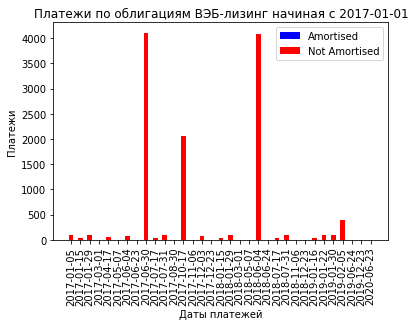

<Figure size 432x288 with 0 Axes>

In [11]:
# Задание 3.2. Визуализация потока платежей с помощью графика вида stacked bar

dates = payment_schedule_sorted.columns
am = payment_schedule.iloc[0]
n_a = payment_schedule_sorted.iloc[1]


p1 = plt.bar(dates, am, width = 0.5, color= 'blue')
p2 = plt.bar(dates, n_a, width = 0.5, bottom = am, color= 'red')

plt.xlabel('Даты платежей')
plt.ylabel('Платежи')
plt.xticks(rotation=90)
plt.title('Платежи по облигациям '+ e + ' начиная с ' + str(f))
b1 = payment_schedule_sorted[payment_schedule_sorted.index.get_level_values('Amortisation') == 'Amortised'].index[0]
b2 = payment_schedule_sorted[payment_schedule_sorted.index.get_level_values('Amortisation') == 'Not Amortised'].index[0]
plt.legend((p1[0], p2[0]), (str(b1), str(b2)))

stacked_bar = plt.show(p1, p2)
stacked_bar

# Сохраняем изображение stacked bar в формате png в рабочей директории

plt.savefig('Платежи по облигациям ВЭБ-лизинг начиная с 2017-01-01.png')

In [ ]:
# ДЗ 4
# После установки jinja2 and weasyprint в Anaconda prompt формируем автоматический отчёт 


from __future__ import print_function
from jinja2 import Environment, FileSystemLoader
from weasyprint import HTML, Document
import os

env = Environment(loader=FileSystemLoader('.'))
template = env.get_template("myreport.html") 
template_vars = {"title": "Отчет составлен Петровым Артемием",
                "INTRO": "Данный отчет содержит информацию по платежам по облигациям ВЭБ-лизинг начиная с 2017-01-01", 
                 "TABLE_DESC": "В таблице представлена матрица платежей по амортизационным и неамортизационным облигациям компании ВЭБ-лизинг", 
                 "TABLE": payment_schedule.to_html(), 
                 "IMAGE_DESC": "На столбчатой диаграмме изображено распределение купонных выплат по амортизационным и неамортизационным облигациям компании ВЭБ-лизинг", 
                 "IMAGE": os.path.realpath('Платежи по облигациям ВЭБ-лизинг начиная с 2017-01-01.png')
                }
# Собираем и печатаем отчет

html_out = template.render(template_vars, presentational_hints=True)
HTML(string=html_out).write_pdf('Veb_leasing_report.pdf', presentational_hints=True)